In [ ]:
!pip install tensorflow
!pip install keras

## Import required packages

In [ ]:
import os
import pandas as pd
import numpy as np
import PIL
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the annotation CSV file
Annotations = pd.read_csv('annotations.csv')
Annotations.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
0,MHIST_aaa.png,SSA,6,train
1,MHIST_aab.png,HP,0,train
2,MHIST_aac.png,SSA,5,train
3,MHIST_aae.png,HP,1,train
4,MHIST_aaf.png,SSA,5,train


In [ ]:
# Check for Imbalanced data
class_counts = Annotations['Majority Vote Label'].value_counts()
print(class_counts)

Majority Vote Label
HP     2162
SSA     990
Name: count, dtype: int64


In [ ]:
# Spliting the test and train data from the dataset file
test_data = Annotations[Annotations['Partition'] == 'test']
train_data = Annotations[Annotations['Partition'] == 'train']

test_data.head()
train_data.shape

(2175, 4)

In [ ]:
#Check for missing values
missing_values = Annotations.isnull().sum()
print(missing_values)

Image Name                                          0
Majority Vote Label                                 0
Number of Annotators who Selected SSA (Out of 7)    0
Partition                                           0
dtype: int64


In [ ]:
# Check for imbalanced data
class_counts = Annotations['Majority Vote Label'].value_counts()
print(class_counts)

Majority Vote Label
HP     2162
SSA     990
Name: count, dtype: int64


In [ ]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/images.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [ ]:
# Match images with labels from the train_data
train_images = {}
for index, row in train_data.iterrows():
    filename_train = row['Image Name']
    label_train = row['Majority Vote Label']
    train_images[filename_train] = label_train

# Assign the labels to images
X_train = []
y_train = []
for filename in train_images:
    image_path = '/content/images/'+filename
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    X_train.append(img_array)

    # Assign label
    if train_images[filename] == 'SSA':
        y_train.append(0)
    elif train_images[filename] == 'HP':
        y_train.append(1)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)



In [ ]:
X_train.shape


(2175, 128, 128, 3)

In [ ]:
# Match images with labels from the test_data
test_images = {}
for index, row in test_data.iterrows():
    filename = row['Image Name']
    label = row['Majority Vote Label']
    test_images[filename] = label

# Assign the labels to images
X_test = []
y_test = []
for filename in test_images:
    image_path = '/content/images/'+filename
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    X_test.append(img_array)

    # Assign label
    if test_images[filename] == 'SSA':
        y_test.append(0)
    elif test_images[filename] == 'HP':
        y_test.append(1)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

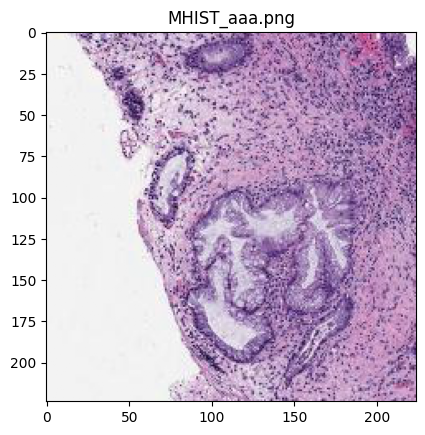

In [ ]:
img = mpimg.imread( '/content/images'+ '/' + Annotations['Image Name'][0])
plt.imshow(img)
plt.title(Annotations['Image Name'][0])
plt.show()

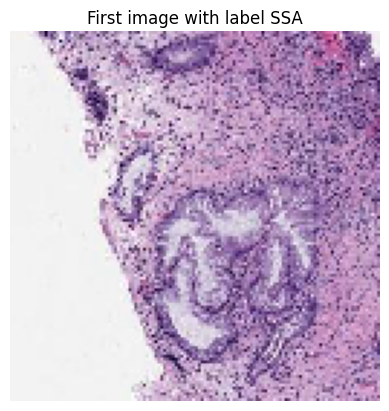

In [ ]:
image_path = '/content/images/' + train_data['Image Name'].iloc[0]
img = load_img(image_path, target_size=(128, 128))

plt.imshow(img)
plt.title('First image with label SSA')
plt.axis('off')  # Turn off axis labels
plt.show()

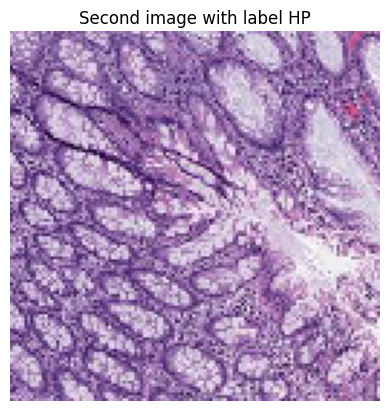

In [ ]:
image_path = '/content/images/' + train_data['Image Name'].iloc[1]
img = load_img(image_path, target_size=(128, 128))

plt.imshow(img)
plt.title('Second image with label HP')
plt.axis('off')  # Turn off axis labels
plt.show()

## Build a Convolution Neural Network


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from functools import reduce
# Create a Sequential model
model = Sequential()

# Add convolutional layers with increasing complexity
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Define the optimizer with an intia learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.002)

# Using the learnig rate
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

In [ ]:
# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 128)      

In [ ]:
# compile the neural network
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2175, 128, 128, 3)
y_train shape: (2175,)
X_test shape: (977, 128, 128, 3)
y_test shape: (977,)


In [ ]:
from re import VERBOSE
from keras import backend as K

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, recall_m, precision_m])

#Evaluate the model
loss, accuracy, f1, recall, precision = model.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Loss: 1.9727004766464233
Accuracy: 0.5854657292366028
F1 Score: 0.6221653819084167
Recall: 0.6415755748748779
Precision: 0.6205809116363525


In [ ]:
from keras import models
model = models.load_model('/content/drive/MyDrive/model.h5', {'f1_m': f1_score, 'precision_m': precision, 'recall_m': recall})

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[reduce_lr])

Epoch 1/10
68/68 [==============================] - 22s 300ms/step - loss: 5.1824 - accuracy: 0.6740 - f1_m: 0.7710 - recall_m: 0.9203 - precision_m: 0.6752 - val_loss: 0.6525 - val_accuracy: 0.6325 - val_f1_m: 0.6716 - val_recall_m: 0.7742 - val_precision_m: 0.6227 - lr: 0.0010
Epoch 2/10
68/68 [==============================] - 20s 297ms/step - loss: 0.5908 - accuracy: 0.7186 - f1_m: 0.8271 - recall_m: 0.9690 - precision_m: 0.7272 - val_loss: 0.7787 - val_accuracy: 0.5271 - val_f1_m: 0.3667 - val_recall_m: 0.2674 - val_precision_m: 0.6672 - lr: 0.0010
Epoch 3/10
68/68 [==============================] - 20s 291ms/step - loss: 0.5637 - accuracy: 0.7251 - f1_m: 0.8270 - recall_m: 0.9564 - precision_m: 0.7391 - val_loss: 0.6364 - val_accuracy: 0.6499 - val_f1_m: 0.6645 - val_recall_m: 0.7534 - val_precision_m: 0.6236 - lr: 0.0010
Epoch 4/10
68/68 [==============================] - 20s 297ms/step - loss: 0.5280 - accuracy: 0.7545 - f1_m: 0.8441 - recall_m: 0.9501 - precision_m: 0.7695 - v

## Model Evaluation

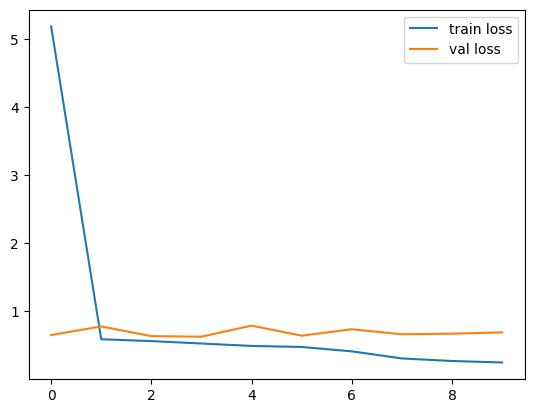

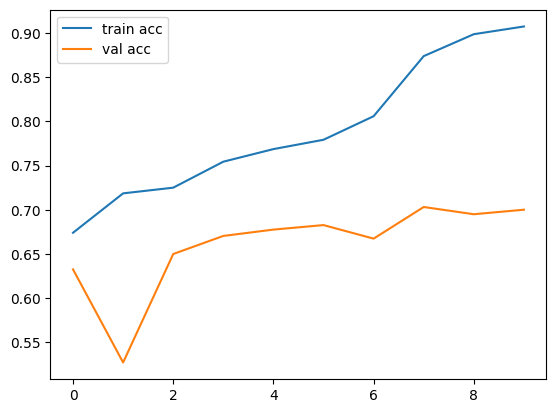

In [ ]:
h = history

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plot the accuracy value
plt.plot(h.history['accuracy'], label='train acc')
plt.plot(h.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_test, y_pred)
print(cm)

31/31 [==============================] - 3s 84ms/step
[[  0 360]
 [  0 617]]


## Building Predictive System

In [ ]:
#Function to load and proces the image
def load_and_preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    #Resize the image
    img = img.resize((128, 128))

    # Convert the image to numpy array
    img = np.array(img)

    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name


## Save the model to google drive or local

In [ ]:
model.save('/content/drive/MyDrive/model.h5')

In [ ]:
model.save('model.h5')